# Imports and Hyperparameters

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import networkit as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, Math, Latex, Markdown
from tqdm.notebook import tqdm

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp, centers
from External.generation import create_graph
from External.plotting import plot_points, plot_graph, no_intersections
from External.data_loader import data_loader
from External.ICT.reduce_to_mst import MST

plt.style.use('standard.mplstyle')

In [5]:
# Hyperparameters
mode = "K_Nearest+Density2"
metric = "euclidean"
dataset = "phate100"

# for the filename
parameters = "2-0_5"

# Data Preperation

In [6]:
start = time.time()

# load the dataset & UMAP embedding (if dim > 2)
position, labels, embedding = data_loader(dataset, True)
# calculate the clusters
cluster_centers = centers(position)
# Save the number of nodes (sometimes needed)
number_of_nodes = len(position)

print("Time for data preperation: ", time.time()-start)

sklearn is done: 3.536055564880371
My own part is done: 0.03894782066345215
Time for data preperation:  3.5820469856262207


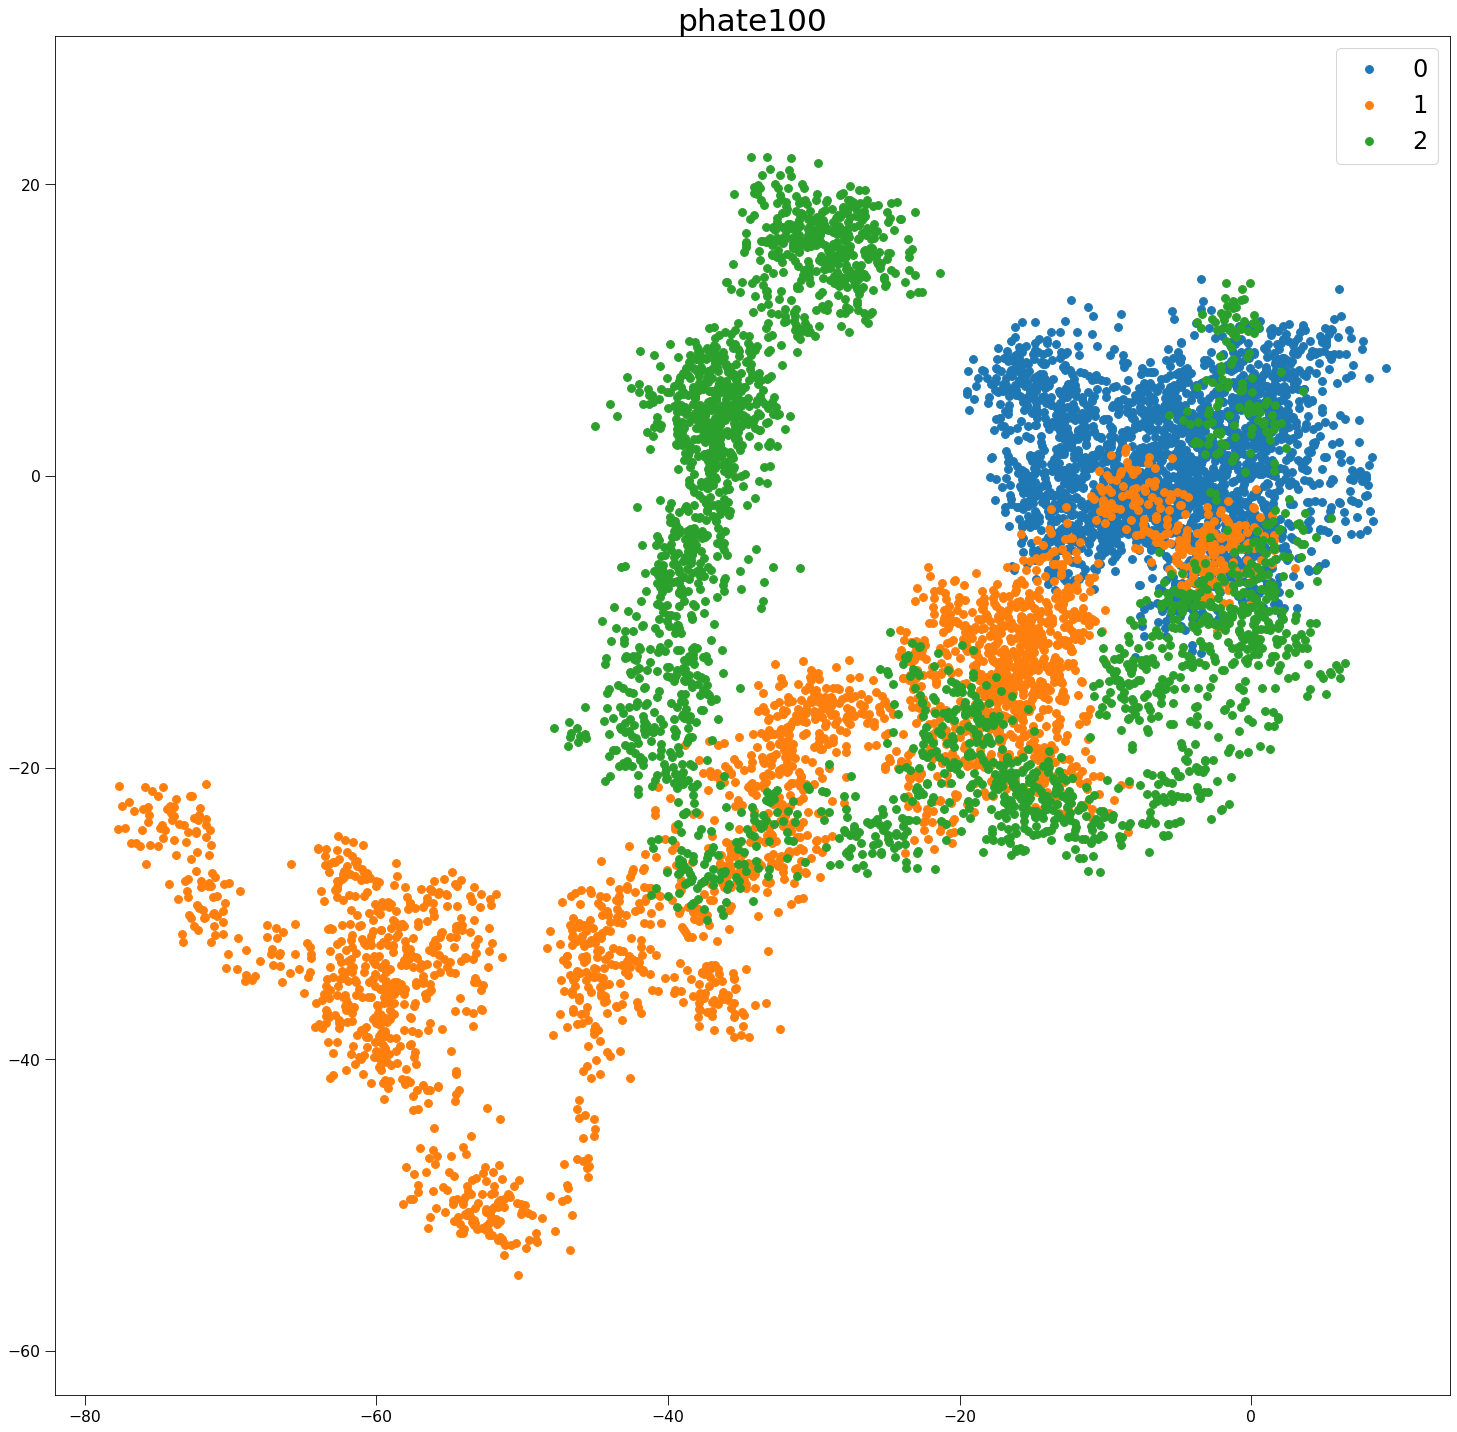

In [7]:
fig, ax = plt.subplots(1, figsize=(24,24))
plot_points(embedding, dataset, ax, labels)
plt.show()

In [8]:
# Create the graph
start = time.time()

if len(position[0]) > 500:
    pca = PCA(n_components=100).fit_transform(StandardScaler().fit_transform(position))
else:
    pca = StandardScaler().fit_transform(position)
    
G, _ = create_graph(number_of_nodes, mode, position=pca, beta=2, delta=0.5)
G.indexEdges()
print("Time for graph construction: ",time.time()-start)

Final k: 11



Time for graph construction:  4.0392537117004395


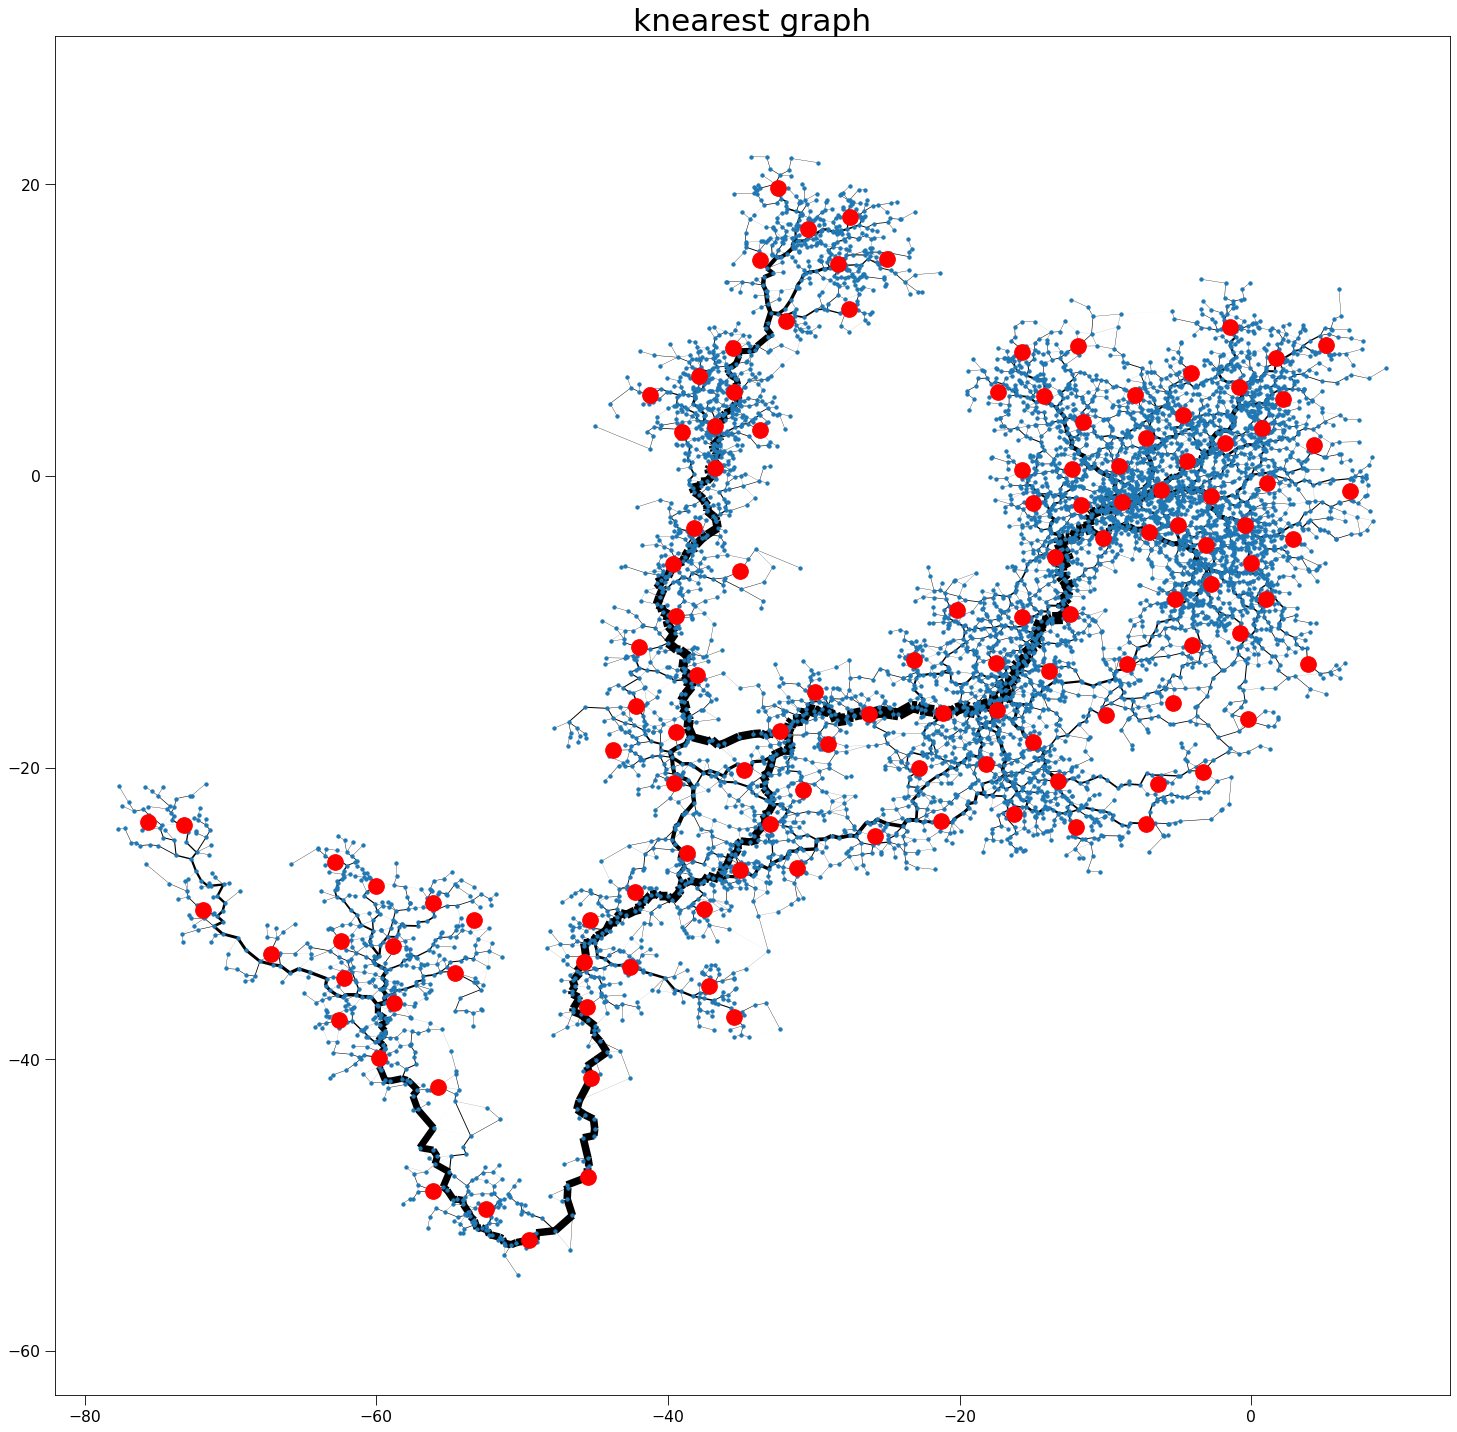

In [9]:
# plot the graph
fig, ax = plt.subplots(1, figsize=(24,24))
plot_graph(G, embedding, "knearest graph", ax, cluster_centers)
plt.show()

## Cluster ICT

In [10]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT.indexEdges()
print("Time for calculating the actual ICT: ", time.time()-start)

update Arr 48410 -> 11871
added 259 edges early
update Arr 11871 -> 10790
added 300 edges early
update Arr 10790 -> 9805
added 285 edges early
update Arr 9805 -> 8906
added 411 edges early
update Arr 8906 -> 8096
added 529 edges early
update Arr 8096 -> 7499
added 473 edges early
added 3472 edges early

Time for calculating the actual ICT:  2947.83531665802


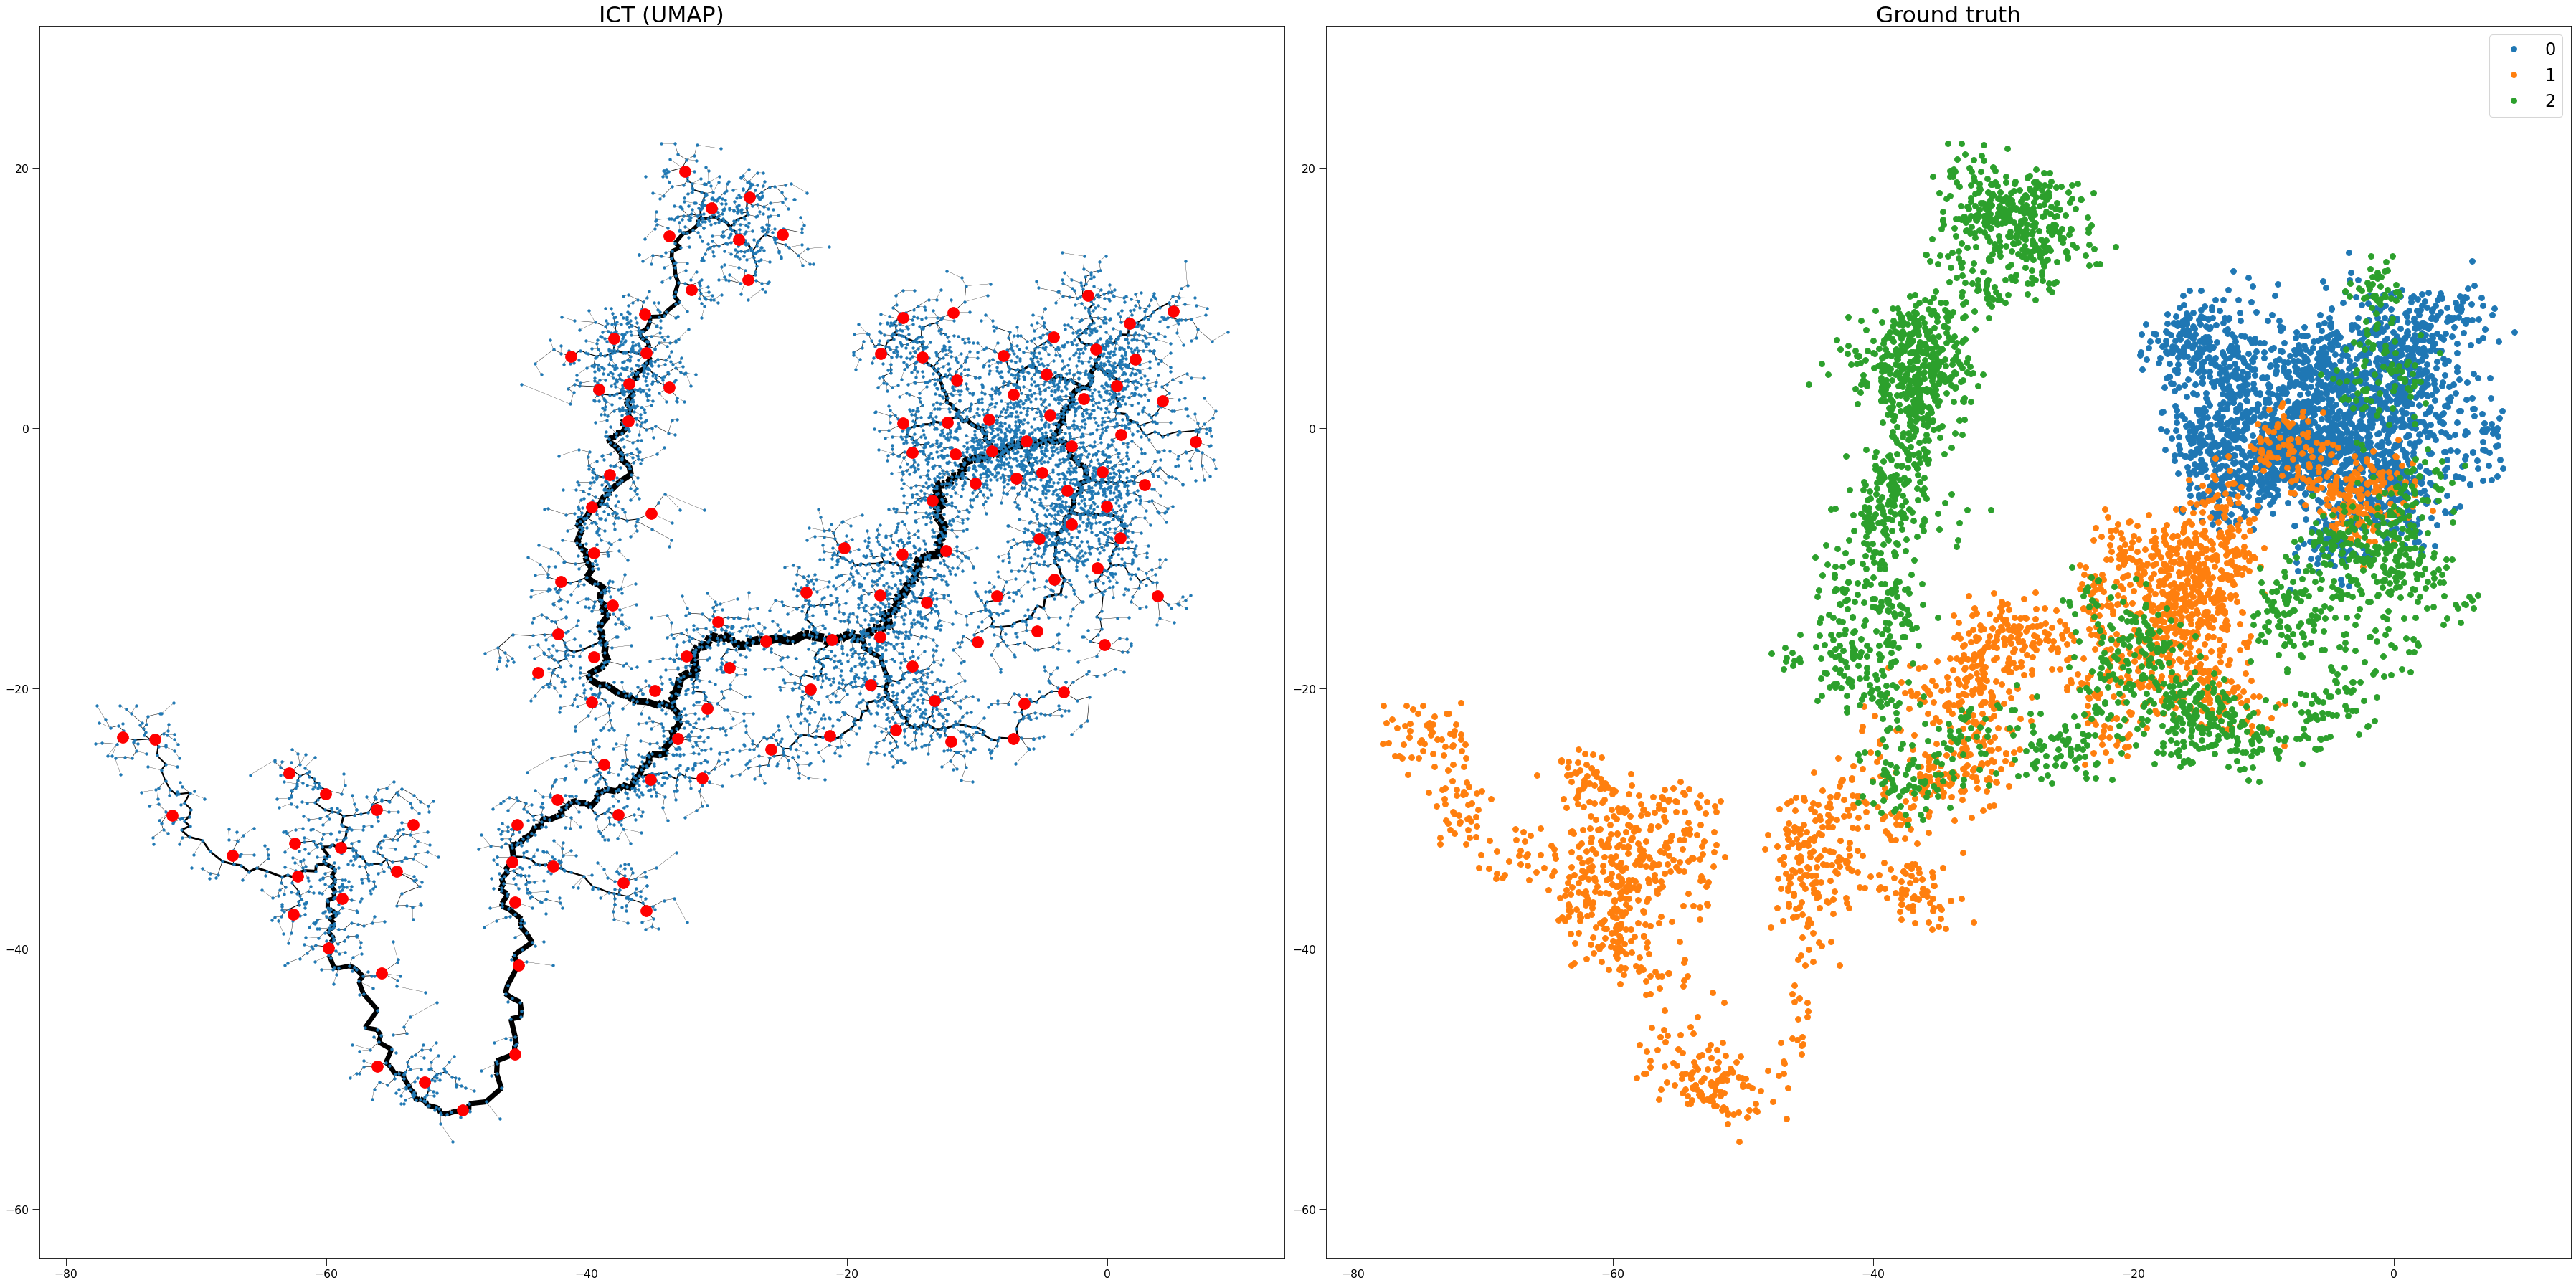

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))

plot_graph(ICT, embedding, "ICT (UMAP)", ax1, cluster_centers)
plot_points(embedding, "Ground truth", ax2, labels)

plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-UMAP-"+parameters+".png")

plt.show()

In [12]:
if (dataset == "pancreas_reduced") or (dataset == "pancreas_full") or (dataset=="eth_CC"):
    if dataset == "pancreas_reduced":
        dtae_embedding, dtae_labels = data_loader("pancreas_reduced_DTAE_embedding")
        
    elif dataset == "pancreas_full":
        dtae_embedding, dtae_labels = data_loader("pancreas_full_DTAE_embedding")
        
    elif dataset=="eth_CC":
        dtae_embedding, dtae_labels = data_loader("CC_DTAE_embedding")
    
    else:
        raise RuntimeError("Something went definitively wrong!?")
        
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
    plot_graph(ICT, dtae_embedding, "ICT (DTAE)", ax1, cluster_centers)
    plot_points(dtae_embedding, "Ground truth", ax2, dtae_labels)
    
    if dataset == "eth_CC":
        ax1.set_xlim([-50,60])
        ax2.set_xlim([-50,60])
        ax1.set_ylim([-45,50])
        ax2.set_ylim([-45,50])
    
    plt.tight_layout()
    plt.savefig("./Output/Images/"+dataset+"-DTAE-"+parameters+".png")
    plt.show()

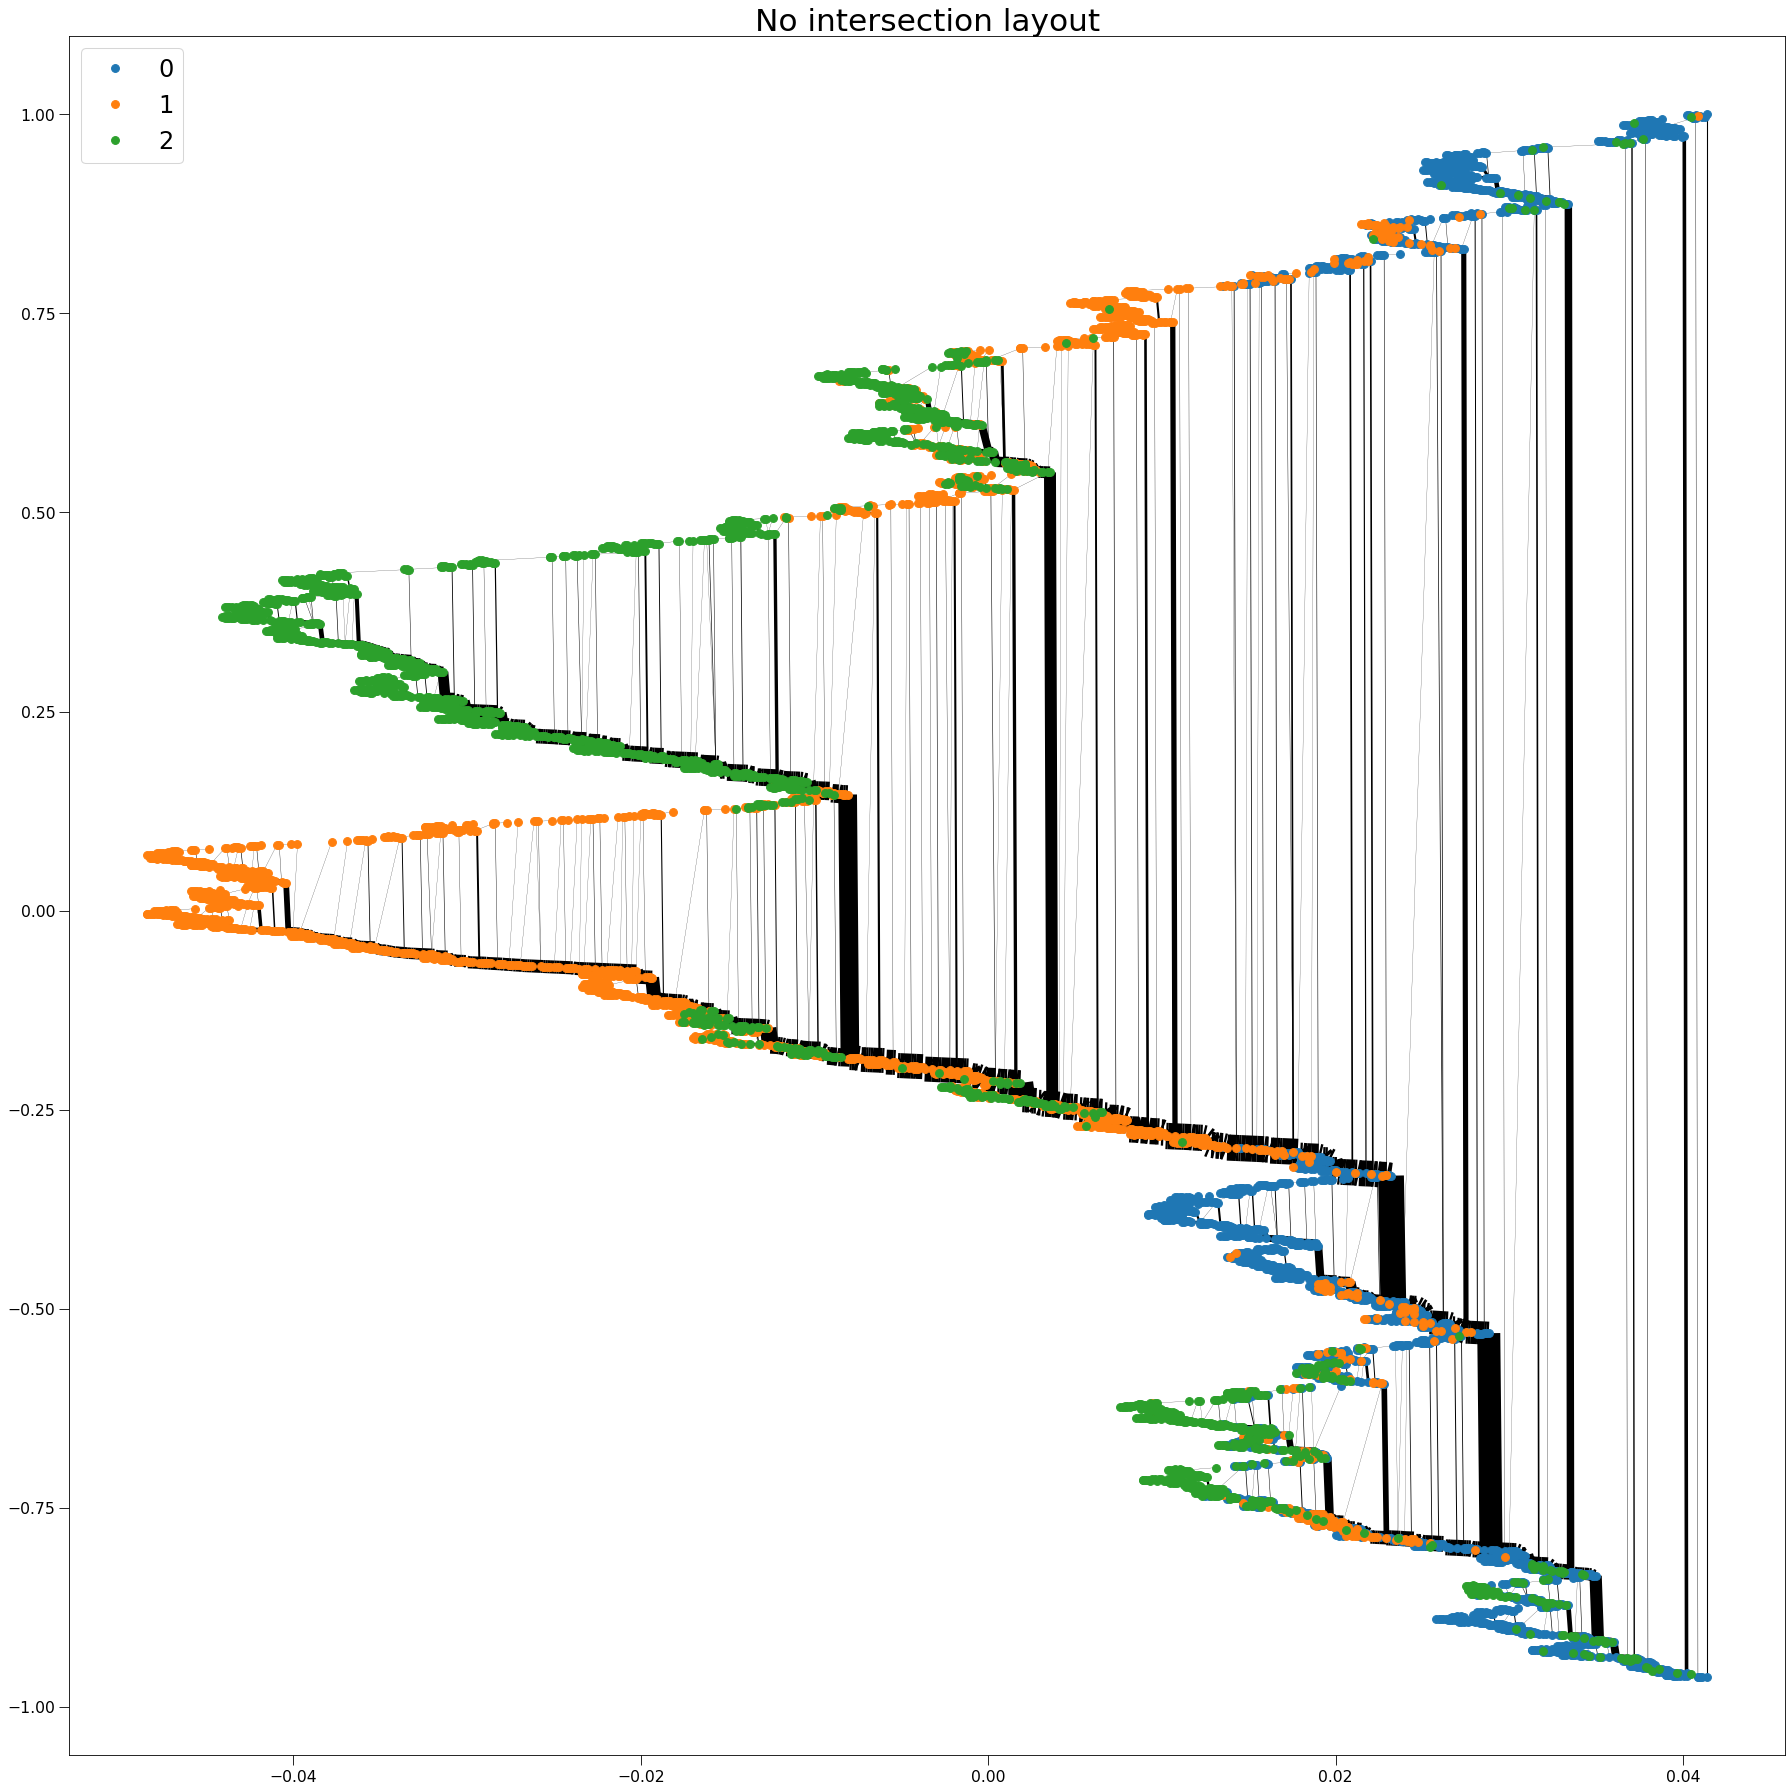

In [13]:
fig, ax = plt.subplots(1, figsize=(24,24))
no_intersections(ICT, embedding, ax, labels)
plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-no-intersection-"+parameters+".png")
plt.show()

# Create the MST for the DTAE autoencoder

### MST created in real space

sklearn is done: 1.9474208354949951
My own part is done: 0.018875598907470703


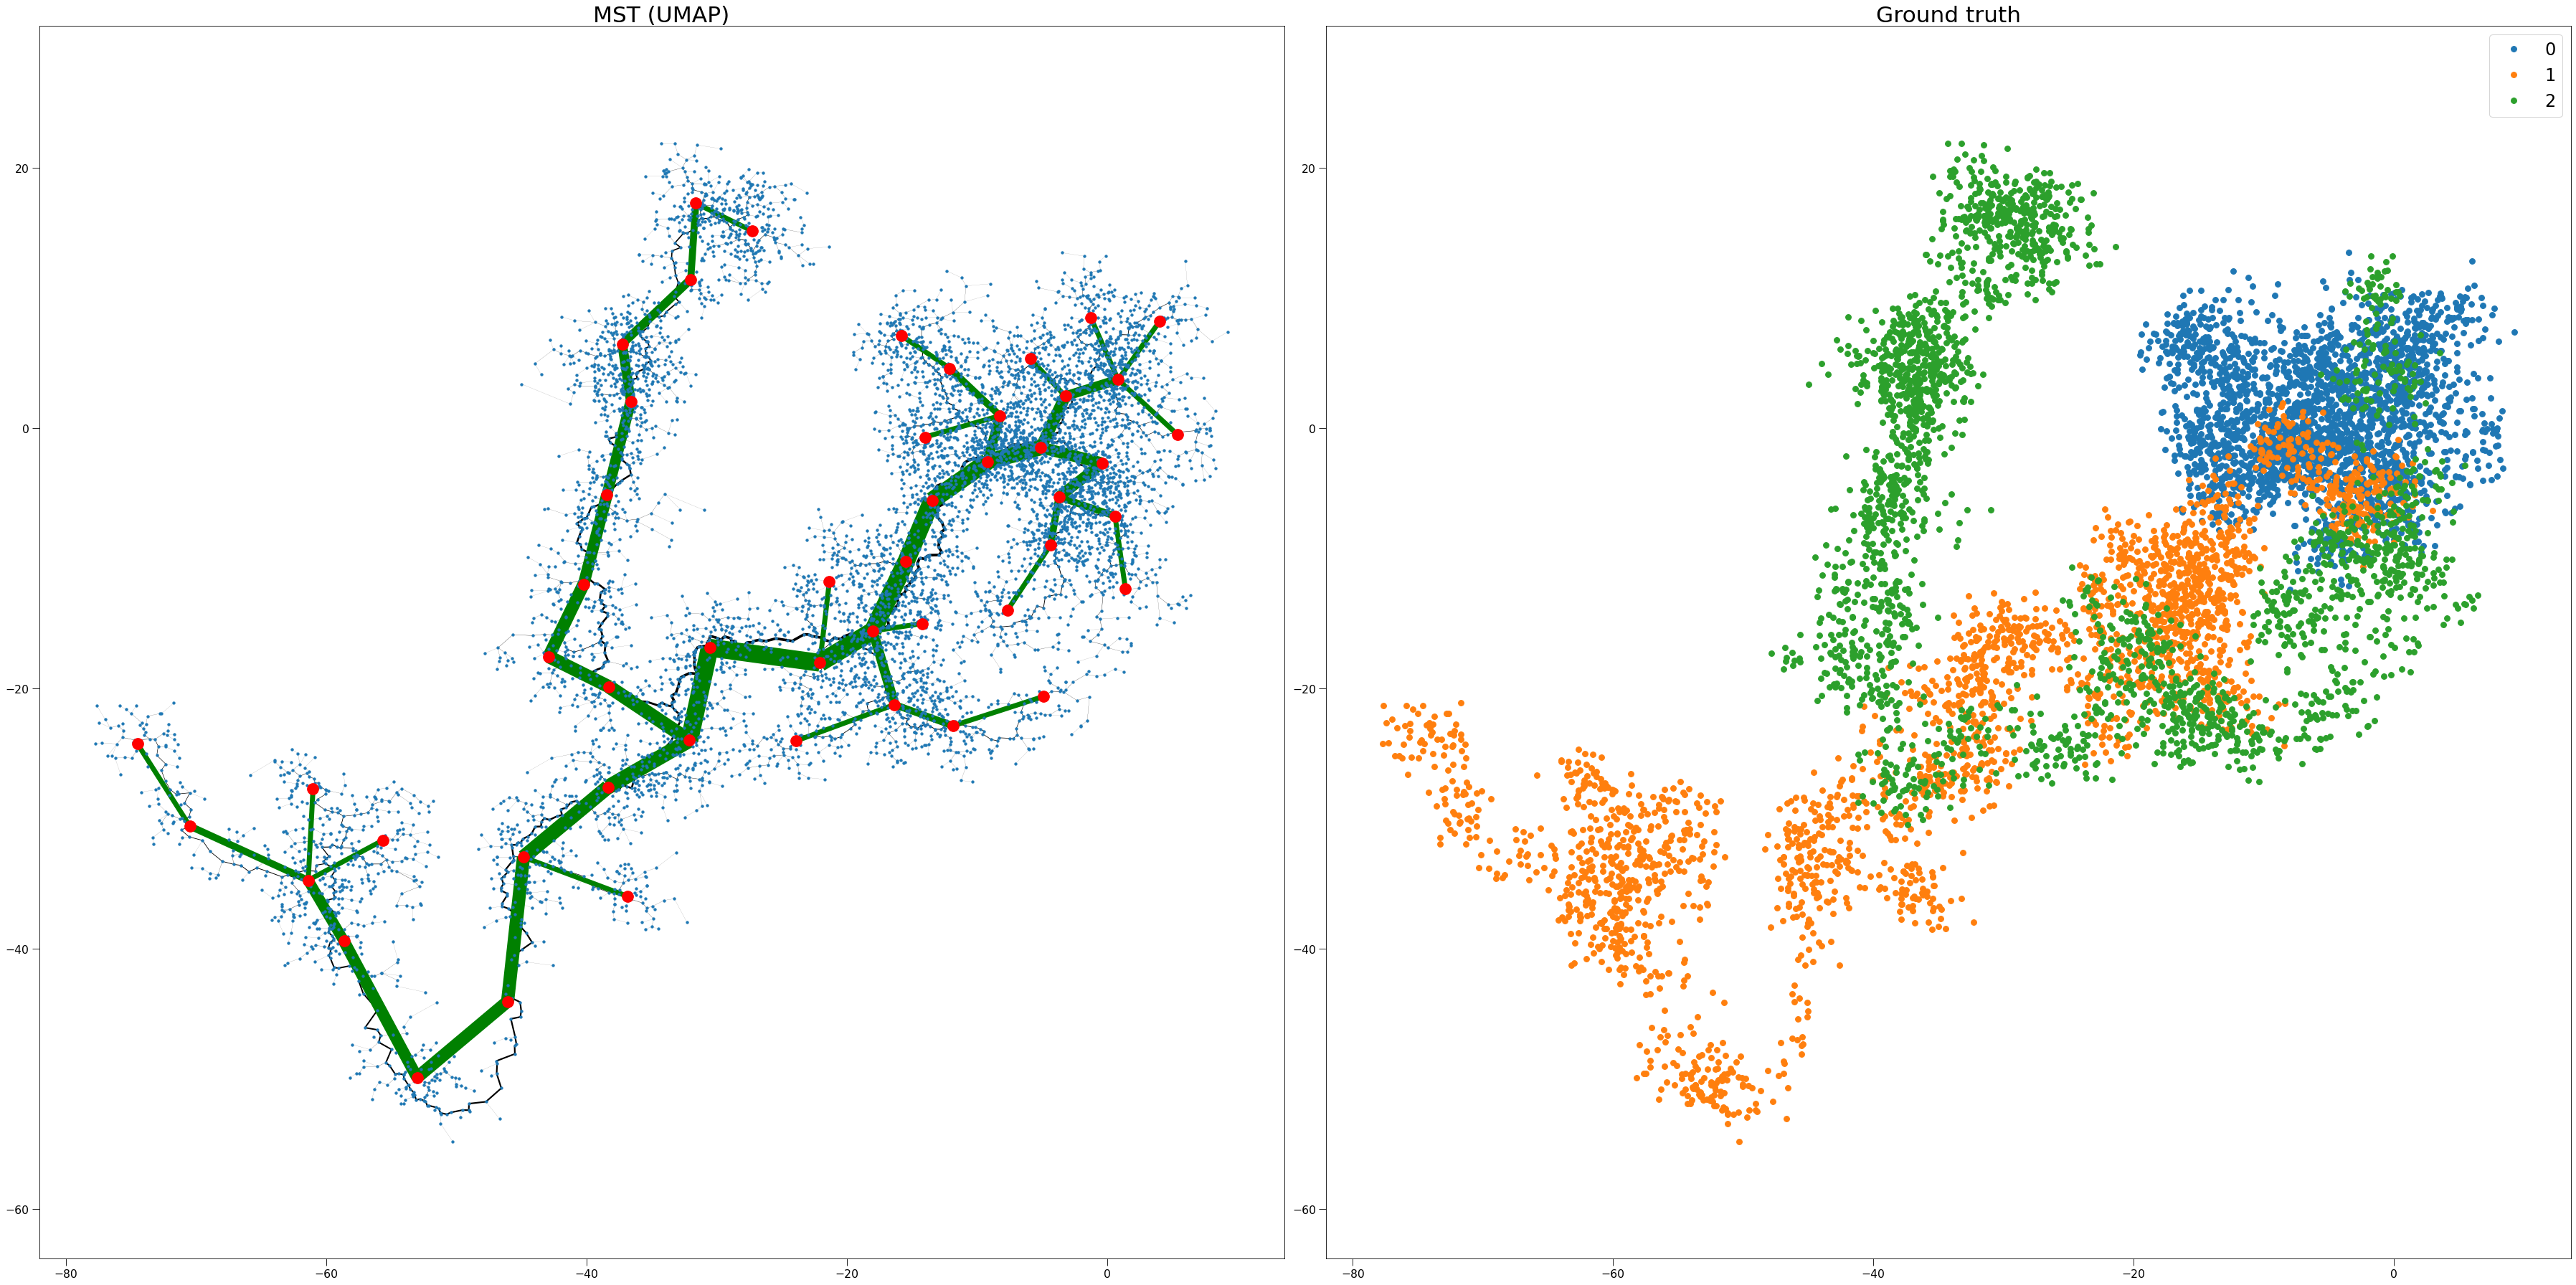

In [14]:
DTAE_centers = k_means_pp(50, position)
mst = MST(ICT, position, DTAE_centers)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
plot_graph(ICT, embedding, "ICT (UMAP)", ax1, DTAE_centers, edge_scale=0.3)
plot_graph(mst, embedding[DTAE_centers], "MST (UMAP)", ax1, edge_scale=2, node_size=0, edge_color="green")
plot_points(embedding, "Ground truth", ax2, labels)

plt.tight_layout()
plt.savefig("./Output/Images/"+dataset+"-MST-"+parameters+".png")

plt.show()

### MST created in PCA space (if it exists)

In [15]:
if len(position[0]) > 500:
    DTAE_centers = k_means_pp(50, position)
    mst = MST(ICT, pca, DTAE_centers)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))
    plot_graph(ICT, embedding, "ICT (UMAP)", ax1, DTAE_centers, edge_scale=0.3)
    plot_graph(mst, embedding[DTAE_centers], "MST (UMAP)", ax1, edge_scale=2, node_size=0, edge_color="green")
    plot_points(embedding, "Ground truth", ax2, labels)

    plt.tight_layout()
    plt.savefig("./Output/Images/"+dataset+"-MST-PCA-"+parameters+".png")
    plt.show()

else:
    print("PCA space was not computed before!")

PCA space was not computed before!
